# Dataset과 DataLoader

* Pytorch는 torch.utils.data.DataLoader와 torch.utils.data.Dataset의 두가지 데이터 기본요소를 제공
* Dataset은 샘플과 정답(label)을 저장
* DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 iterable 객체로 감쌈.
* 데이터셋은 torch.utils.data.Dataset의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있음.
* 모델을 만들어보고(prototype), 성능을 측정(benchmark)하는데 사용할 수 있음.

## 데이터셋 불러오기

* Fashion MNIST
* 60000개의 trainset, 10000개의 testset
* 이미지와 label(정답, 10개의 클래스 중 하나)

다음 매개변수들을 사용하여 데이터셋을 불러옴.
* root
* train : 학습용 또는 테스트용 데이터셋 여부를 지정
* download=True
* transform과 target_transform은 특징(feature)과 정답(label) 변형(transform)을 지정

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 데이터셋을 순회하고 시각화하기

Dataset에 리스트처럼 직접 접근할 수 있음.

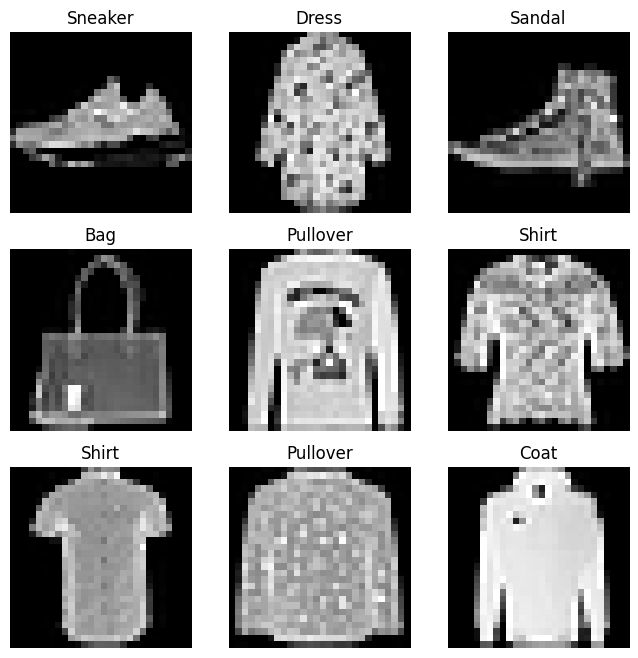

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개의 함수를 구현해야한다. __init__, __len__, __getitem__

FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장된다. 

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

__init__ 함수는 Dataset 객체가 생성될 때 한번만 실행
이미지와 주석파일(annotation_file)이 포함된 디렉토리와 두가지 transform을 초기화

__len__ 함수는 데이터셋의 샘플개수 반환

__getitem__ 함수는 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환. 인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고, read_image를 사용하여 이미지를 텐서로 변환하고, self.img_labels의 csv 데이터로부터 해당하는 정답(label)을 가져오고, 해당하는 경우 transform 함수들을 호출한 뒤, 텐서이미지와 라벨을 딕셔너리형으로 반환

## DataLoader로 학습용 데이터 준비하기

Dataset은 데이터셋의 feature를 가져오고 하나의 샘플에 label(정답)을 지정하는 일을 한번에 함.

모델을 학습할 때, 일반적으로 샘플들을 미니배치로 전달하고, 매 에포크 마다 데이터를 다시 섞어서 overfitting을 막고, python의 multiprocessing을 사용하여 데이터 검색속도를 높이려고 함.

DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회가능한 객체(iterable)

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 순회하기(iterate)

DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있음. 각 iteration은(각각 batch_size=64의 feature과 label을 포함하는) train_features와 train_labels의 batch(묶음)을 반환. shuffle=True로 지정하면 모든 배치를 순회한 뒤 데이터가 섞임.

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape :  torch.Size([64])


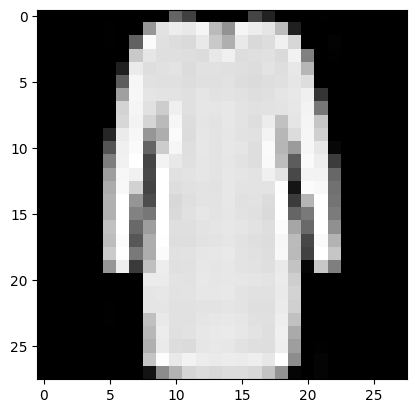

Label : 3


In [5]:
# 이미지의 정답(label) 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Labels batch shape :  {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap='gray')
plt.show()
print(f'Label : {label}')